# Pointer Network

In [1]:
import torch 
import torch.nn as nn # Neural network module
import torch.optim as optim # Optimization module
import torch.nn.functional as F # Functional module
import matplotlib.pyplot as plt
import numpy as np
import random

from torch.utils.data import DataLoader, Dataset, random_split

**Pointer Network**, also known as Ptr-Net, is a neural network architecture introduced by Oriol Vinyals, Meire Fortunato, and Navdeep Jaitly in their 2015 paper "Pointer Networks". Pointer Networks are a type of neural network that can learn to generate sequences by pointing to positions in the input sequence. Conventional sequence-to-sequence models like RNNs, LSTMs, and Transformers generate sequences by predicting the next token in the output sequence at each time step. In contrast, Pointer Networks generate sequences by selecting positions in the input sequence as output.

Pointer Networks use attention mechanisms to directly select positions in the input sequence as output. This capability is particularly useful for problems like the Traveling Salesman Problem (TSP), the Delaunay Triangulation, and various other combinatorial problems where the solution is a sequence derived from a given set of inputs. 

In this notebook, we will implement a Pointer Network to solve the sorting problem. Given a sequence of numbers, the Pointer Network will learn to sort the numbers in ascending order by selecting positions in the input sequence as output. We will use the PyTorch library to implement the Pointer Network and train it on a synthetic dataset of unsorted sequences.

## Sequence-to-Sequence Models

> To write this section, I referred to the following resources:
> - Sutskever, Ilya, Oriol Vinyals, and Quoc V. Le. *Sequence to sequence learning with neural networks.* Advances in neural information processing systems 27 (2014).
> - Cho, Kyunghyun, et al. *Learning phrase representations using RNN encoder-decoder for statistical machine translation.* arXiv preprint arXiv:1406.1078 (2014).
> ---

**Sequence-to-sequence models** (Seq2Seq) are a class of neural networks that take a sequence as input and produce a sequence as output. They are widely used in machine translation, text summarization, speech recognition, and other sequence generation tasks. 

The basic architecture of a sequence-to-sequence model consists of an **encoder** and a **decoder**. The encoder processes the input sequence and encodes it into a fixed-size representation, while the decoder generates the output sequence based on the encoded representation. Specifically,

1. The encoder processes the input sequence and compresses the information into a fixed-size **context vector**. This context vector encapsulates the entire information of the input sequence. The encoder can be an RNN, LSTM, or GRU network that processes the input sequence one element at a time and produces a sequence of hidden states.

2. The decoder generates the output sequence from the context vector provided by the encoder. Similar to the encoder, the decoder can also be an RNN, LSTM, or GRU network. It produces one element of the output sequence at a time and can use the previously generated elements as additional input.

We talk about the mathematical formulation of the sequence-to-sequence model. At this point, we use Recurrent Neural Networks (RNNs) as the building blocks of the encoder and decoder. However, it is important to note that other architectures like Long Short-Term Memory (LSTMs) networks and Gated Recurrent Units (GRUs) can also be used in place of RNNs.

Given an input sequence $\mathbf{X} = (\mathbf{x}_1, \mathbf{x}_2, \ldots, \mathbf{x}_T)$ and an output sequence $\mathbf{Y} = (\mathbf{y}_1, \mathbf{y}_2, \ldots, \mathbf{y}_{T})$ where $\mathbf{x}_t, \mathbf{y}_t \in \mathbb{R}^{d \times 1}$, the encoder processes the input sequence to obtain a sequence of hidden states $\mathbf{H} = (\mathbf{h}_1, \mathbf{h}_2, \ldots, \mathbf{h}_T)$. The hidden state $\mathbf{h}_t \in \mathbb{R}^{p\times 1}$ at time step $t$ is computed as a function of the input $\mathbf{x}_t$ and the previous hidden state $\mathbf{h}_{t-1}$, i.e., $\mathbf{h}_t = f(\mathbf{x}_t, \mathbf{h}_{t-1})$. We can choose the function $f$ to be a simple linear transformation followed by an activation function, such as the $\text{sigmoid}$ or $\text{tanh}$ function.

\begin{equation}
\mathbf{h}_t = \text{sigmoid}\left(\mathbf{W}^{\text{hx}} \mathbf{x}_t + \mathbf{W}^{\text{hh}} \mathbf{h}_{t-1}\right) \tag{1}
\end{equation}

where $\mathbf{W}^{\text{hx}} \in \mathbb{R}^{p\times d}$ and $\mathbf{W}^{\text{hh}} \in \mathbb{R}^{p\times p}$ are the weight matrices, and $\text{sigmoid}$ is the activation function. The initial hidden state $\mathbf{h}_0$ is usually set to zero. The context vector is computed as the last hidden state $\mathbf{h}_T$.

We can rewrite the above equation in matrix form as follows:

\begin{equation}
\mathbf{h}_t = \text{sigmoid}\left( \underbrace{\begin{bmatrix} \mathbf{W}^{\text{hx}} & \mathbf{W}^{\text{hh}} \end{bmatrix}}_{\mathbf{W}} \begin{bmatrix} \mathbf{x}_t \\ \mathbf{h}_{t-1}\end{bmatrix} \right) \tag{1}
\end{equation}

where $\mathbf{W} \in \mathbb{R}^{p\times (d+p)}$ is the weight matrix. The concatenation of $\mathbf{x}_t$ and $\mathbf{h}_{t-1}$ which is a collumn vector of size $(d+p)$ is fed to the weight matrix $\mathbf{W}$ to compute the hidden state $\mathbf{h}_t$.

The output is computed by following equation:

\begin{equation}
\mathbf{y}_t = \mathbf{W}^{\text{hy}} \mathbf{h}_t \tag{2}
\end{equation}

where $\mathbf{W}^{\text{hy}} \in \mathbb{R}^{d\times p}$ is the weight matrix.

In [6]:
# Implementing a simple RNN
class RNN(nn.Module):
	def __init__(self, input_size, hidden_size, output_size):
		super(RNN, self).__init__()
		self.hidden_size = hidden_size
		self.input_size = input_size
		self.output_size = output_size

		# Define linear layers
		self.i2h = nn.Linear(input_size + hidden_size, hidden_size) # W^ih * [x_t, h_t-1]
		self.h2o = nn.Linear(hidden_size, output_size) # W^ho * h_t

		# Define activation function
		self.activation = nn.Sigmoid()

	def forward(self, input, hidden):
		combined = torch.cat((input, hidden), 1) # [x_t, h_t-1], torch.cat concatenates along the second dimension
		hidden = self.activation(self.i2h(combined)) # h_t = sigmoid(W^ih * [x_t, h_t-1])
		output = self.h2o(hidden) # y_t = W^ho * h_t
		return output, hidden # Need to return hidden state for next time step
	
	def init_hidden(self):
		return torch.zeros(1, self.hidden_size) # Initialize hidden state to zeros, which is the same as h_0

Epoch 0 Loss: 48.11879348754883
Epoch 100 Loss: 0.04491451010107994
Epoch 200 Loss: 0.002114828210324049
Epoch 300 Loss: 0.0006631762371398509
Epoch 400 Loss: 0.0002964616578537971
Epoch 500 Loss: 0.00016455202421639115
Epoch 600 Loss: 0.00011110841296613216
Epoch 700 Loss: 8.592118683736771e-05
Epoch 800 Loss: 0.010202344506978989
Epoch 900 Loss: 7.951374573167413e-05
Test loss: 0.024877655746716455


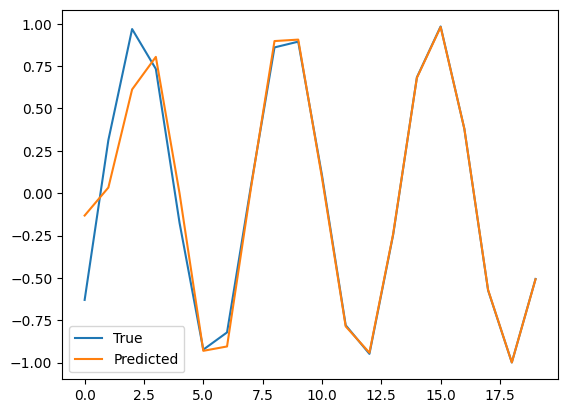

In [12]:
# Generate data using a simple sine wave
np.random.seed(0)
torch.manual_seed(0)

def generate_data(seq_length):
	time_steps = np.linspace(0, 100, seq_length + 1)
	data = np.sin(time_steps)
	x = data[:-1]
	y = data[1:]
	return x, y

x, y = generate_data(100)

# Split data into training and testing
train_size = 80
x_train, y_train = x[:train_size], y[:train_size]
x_test, y_test = x[train_size:], y[train_size:]

model = RNN(1, 50, 1)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

for epoch in range(1000):
	loss = 0
	hidden = model.init_hidden()
	optimizer.zero_grad()
	for i in range(x_train.shape[0]):
		input = torch.tensor(x_train[i]).float().view(1, 1)
		target = torch.tensor(y_train[i]).float().view(1, 1)
		prediction, hidden = model(input, hidden)
		loss += criterion(prediction, target)
	loss.backward()
	optimizer.step()
	if epoch % 100 == 0:
		print(f'Epoch {epoch} Loss: {loss.item()}')

# Test the model
hidden = model.init_hidden()
predictions = []
for i in range(x_test.shape[0]):
	input = torch.tensor(x_test[i]).float().view(1, 1)
	target = torch.tensor(y_test[i]).float().view(1, 1)
	prediction, hidden = model(input, hidden)
	predictions.append(prediction.item())

# Print error on test set
test_loss = criterion(torch.tensor(predictions), torch.tensor(y_test))
print(f'Test loss: {test_loss.item()}')

# Plot the results
plt.plot(y_test, label='True')
plt.plot(predictions, label='Predicted')
plt.legend()
plt.show()

The RNN can easily map the input sequence to the output sequence when the input and output sequences have the same length. However, in many sequence-to-sequence tasks, the input and output sequences have different lengths. In such cases, the encoder-decoder architecture with RNNs faces difficulty in capturing long-range dependencies and handling variable-length sequences.

The simplest solution for general sequence-to-sequence tasks is to map the input sequence to a fixed-size context vector using one RNN and then use another RNN to generate the output sequence from the context vector. That model is called **RNN Encoder-Decoder**.

The output sequence $\mathbf{Y} = (\mathbf{y}_1, \mathbf{y}_2, \ldots, \mathbf{y}_{T'})$ may have different length from the input sequence $\mathbf{X} = (\mathbf{x}_1, \mathbf{x}_2, \ldots, \mathbf{x}_T)$. From a probabilistic perspective, this model is general method to learn the conditional probability of the output sequence given the input sequence, i.e., 

\begin{equation}
\mathbb{P}(\mathbf{Y}|\mathbf{X}) = \mathbb{P}\left(\mathbf{y}_1, \mathbf{y}_2, \ldots, \mathbf{y}_{T'}|\mathbf{x}_1, \mathbf{x}_2, \ldots, \mathbf{x}_T\right) \tag{3}
\end{equation}

The encoder reads each element of the input sequence $\mathbf{X}$ sequentially. After reading the last element, the encoder produces a fixed-size context vector $\mathbf{c}$ that summarizes the entire input sequence. The decoder as the second RNN is then trained to generate the output sequence $\mathbf{Y}$ by predicting the next element of the output sequence given the context vector $\mathbf{c}$ and the hidden state of the decoder which is updated at each time step $t$ as follows:

\begin{equation}
\mathbf{h}_t = f(\mathbf{h}_{t-1}, \mathbf{y}_{t-1}, \mathbf{c}) \tag{4}
\end{equation}

The conditional distribution of the next element $\mathbf{y}_t$ given the previous elements $\mathbf{y}_{t-1},\mathbf{y}_{t-2},\ldots,\mathbf{y}_1$ and the context vector $\mathbf{c}$ is computed as follows:

\begin{equation}
\mathbb{P}(\mathbf{y}_t|\mathbf{y}_{t-1},\mathbf{y}_{t-2},\ldots,\mathbf{y}_1, \mathbf{c}) = g(\mathbf{h}_t, \mathbf{y}_{t-1}, \mathbf{c}) \tag{5}
\end{equation}

where $g$ is a function that maps the hidden state $\mathbf{h}_t$, the previous output element $\mathbf{y}_{t-1}$, and the context vector $\mathbf{c}$ to the probability distribution over the output vocabulary.

The two components of the RNN Encoder-Decoder model are trained jointly to maximize the likelihood of the output sequence given the input sequence which is equivalent to minimizing the negative log-likelihood of the output sequence given the input sequence. The loss function is defined as the sum of the negative log-likelihood of the output sequence:

\begin{equation}
\max_{\theta} \frac{1}{N} \sum_{i=1}^{N} \log \mathbb{P}\left(\mathbf{Y}^{(i)}|\mathbf{X}^{(i)};\theta\right) \tag{6}
\end{equation}

where $\theta$ denotes the parameters of the model, $\mathbf{X}^{(i)}$ and $\mathbf{Y}^{(i)}$ are the input and output sequences of the $i$-th training example, and $N$ is the total number of training examples.

## Encoder 

Here we define the encoder of the RNN Encoder-Decoder model as a GRU network. The hidden state of the encoder is computed using the GRU cell at each time step.

\begin{equation}
\mathbf{h}_t = \mathbf{z}_t \odot \mathbf{h}_{t-1} + (1 - \mathbf{z}_t) \odot \tilde{\mathbf{h}}_t \tag{7}
\end{equation}

where $\mathbf{z}_t$ is the update gate, $\tilde{\mathbf{h}}_t$ is the candidate hidden state, and $\odot$ denotes element-wise multiplication. The update gate $\mathbf{z}_t$ and the candidate hidden state $\tilde{\mathbf{h}}_t$ are computed as follows:

\begin{align*}
\mathbf{z}_t & = \sigma\left(\mathbf{W}^{\text{zx}} \mathbf{x}_t + \mathbf{W}^{\text{zh}} \mathbf{h}_{t-1}\right) = \sigma\left(\mathbf{W}^{\text{z}} \begin{bmatrix} \mathbf{x}_t \\ \mathbf{h}_{t-1}\end{bmatrix}\right) \tag{8.1} \\
\mathbf{r}_t & = \sigma\left(\mathbf{W}^{\text{rx}} \mathbf{x}_t + \mathbf{W}^{\text{rh}} \mathbf{h}_{t-1}\right) = \sigma\left(\mathbf{W}^{\text{r}} \begin{bmatrix} \mathbf{x}_t \\ \mathbf{h}_{t-1}\end{bmatrix}\right) \tag{8.2} \\
\tilde{\mathbf{h}}_t & = \phi\left(\mathbf{W}^{\text{hx}} \mathbf{x}_t + \mathbf{W}^{\text{hh}} (\mathbf{r}_t \odot \mathbf{h}_{t-1})\right) = \phi\left(\mathbf{W}^{\text{h}} \begin{bmatrix} \mathbf{x}_t \\ \mathbf{r}_t \odot \mathbf{h}_{t-1}\end{bmatrix}\right) \tag{8.3}
\end{align*}

where $\sigma$ is the sigmoid activation function, $\phi$ is the hyperbolic tangent activation function, and $\mathbf{W}^{\text{z}}$, $\mathbf{W}^{\text{r}}$, and $\mathbf{W}^{\text{h}}$ are the weight matrices for the update gate, reset gate, and candidate hidden state, respectively. Denote $d$ as the dimension of the input $\mathbf{x}_t$ and $p$ as the dimension of the hidden state $\mathbf{h}_t$, the meaning of the symbols are as follows:

* $\mathbf{x}_t \in \mathbb{R}^{d\times 1}$ is the input at time step $t$.
* $\mathbf{h}_{t-1} \in \mathbb{R}^{p\times 1}$ is the previous hidden state.
* $\tilde{\mathbf{h}}_t \in \mathbb{R}^{p\times 1}$ is the candidate hidden state.
* $\mathbf{z}_t \in (0, 1)^{p\times 1}$ is the update gate.
* $\mathbf{r}_t \in (0, 1)^{p\times 1}$ is the reset gate.
* $\mathbf{W}^{\text{zx}} \in \mathbb{R}^{p\times d}$, $\mathbf{W}^{\text{zh}} \in \mathbb{R}^{p\times p}$, $\mathbf{W}^{\text{rx}} \in \mathbb{R}^{p\times d}$, $\mathbf{W}^{\text{rh}} \in \mathbb{R}^{p\times p}$, $\mathbf{W}^{\text{hx}} \in \mathbb{R}^{p\times d}$, $\mathbf{W}^{\text{hh}} \in \mathbb{R}^{p\times p}$ are the weight matrices.

The input sequence $\mathbf{x}$ has a length $T$, once the hidden state $\mathbf{h}_T$ is computed, it is used as the context vector to generate the output sequence.

\begin{equation}
\mathbf{c} = \tanh \left(\mathbf{W}^{\text{ch}} \mathbf{h}_T\right) \tag{9}
\end{equation}

where $\mathbf{W}^{\text{ch}} \in \mathbb{R}^{p\times p}$ is the weight matrix and $\mathbf{c} \in \mathbb{R}^{p\times 1}$ is the context vector.

In [7]:
# Implement a RNN encoder-decoder

# Encoder based on GRU
class SimpleGRUEncoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hidden_dim, dropout=0.5):
        super(SimpleGRUEncoder, self).__init__()
        self.hidden_dim = hidden_dim
        
        self.embedding = nn.Embedding(input_dim, emb_dim)
        self.dropout = nn.Dropout(dropout)
        
        self.W_z = nn.Linear(emb_dim + hidden_dim, hidden_dim)
        self.W_r = nn.Linear(emb_dim + hidden_dim, hidden_dim)
        self.W_h = nn.Linear(emb_dim + hidden_dim, hidden_dim)

    def forward(self, src):
        # src: [src_len, batch_size]
        embedded = self.dropout(self.embedding(src))
        # embedded: [src_len, batch_size, emb_dim]

        h = torch.zeros(src.size(1), self.hidden_dim).to(src.device)
        # Initialize hidden state h: [batch_size, hidden_dim]

        for t in range(src.size(0)):
            h = self.gru_cell(embedded[t], h)
        
        return h

    def gru_cell(self, x_t, h_prev):
        # x_t: [batch_size, emb_dim]
        # h_prev: [batch_size, hidden_dim]
        
        combined = torch.cat((x_t, h_prev), dim=1)
        # combined: [batch_size, emb_dim + hidden_dim]
        
        z_t = torch.sigmoid(self.W_z(combined))
        r_t = torch.sigmoid(self.W_r(combined))
        
        combined_reset = torch.cat((x_t, r_t * h_prev), dim=1)
        h_tilde_t = torch.tanh(self.W_h(combined_reset))
        
        h_t = z_t * h_prev + (1 - z_t) * h_tilde_t
        
        return h_t

## Decoder

The decoder is also a GRU network that generates the output sequence based on the context vector provided by the encoder. It starts with the initial hidden state $\mathbf{h}_0$ which is computed as a function of the context vector $\mathbf{c}$.

\begin{equation}
\mathbf{h}_0 = \tanh\left(\mathbf{W}^{\text{hc}} \mathbf{c}\right) \tag{10}
\end{equation}

where $\mathbf{W}^{\text{hc}} \in \mathbb{R}^{p\times p}$ is the weight matrix.

The hidden state $\mathbf{h}_t$ at time step $t$ is computed using the GRU cell as follows:

\begin{equation}
\mathbf{h}_t = \mathbf{z}_t \odot \mathbf{h}_{t-1} + (1 - \mathbf{z}_t) \odot \tilde{\mathbf{h}}_t \tag{11}
\end{equation}

where $\mathbf{z}_t$ is the update gate, $\tilde{\mathbf{h}}_t$ is the candidate hidden state, and they are computed as follows:

\begin{align*}
\mathbf{z}_t & = \sigma\left(\mathbf{W}^{\text{zx}} \mathbf{y}_{t-1} + \mathbf{W}^{\text{zh}} \mathbf{h}_{t-1} + \mathbf{W}^{\text{zc}} \mathbf{c}\right) = \sigma\left(\mathbf{W}^{\text{z}} \begin{bmatrix} \mathbf{y}_{t-1} \\ \mathbf{h}_{t-1} \\ \mathbf{c}\end{bmatrix}\right) \tag{12.1} \\
\mathbf{r}_t & = \sigma\left(\mathbf{W}^{\text{rx}} \mathbf{y}_{t-1} + \mathbf{W}^{\text{rh}} \mathbf{h}_{t-1} + \mathbf{W}^{\text{rc}} \mathbf{c}\right) = \sigma\left(\mathbf{W}^{\text{r}} \begin{bmatrix} \mathbf{y}_{t-1} \\ \mathbf{h}_{t-1} \\ \mathbf{c}\end{bmatrix}\right) \tag{12.2} \\
\tilde{\mathbf{h}}_t & = \phi\left(\mathbf{W}^{\text{hx}} \mathbf{y}_{t-1} + \mathbf{r}_t \odot \left( \mathbf{W}^{\text{hh}} \mathbf{h}_{t-1} + \mathbf{W}^{\text{hc}} \mathbf{c} \right)\right) \tag{12.3}
\end{align*}

The symbols have the similar meaning as in the encoder:

* $\mathbf{y}_{t-1} \in \mathbb{R}^{d\times 1}$ is the previous output at time step $t-1$.
* $\mathbf{h}_{t-1} \in \mathbb{R}^{p\times 1}$ is the previous hidden state.
* $\tilde{\mathbf{h}}_t \in \mathbb{R}^{p\times 1}$ is the candidate hidden state.
* $\mathbf{z}_t \in (0, 1)^{p\times 1}$ is the update gate.
* $\mathbf{r}_t \in (0, 1)^{p\times 1}$ is the reset gate.
* $\mathbf{W}^{\text{zx}} \in \mathbb{R}^{p\times d}$, $\mathbf{W}^{\text{zh}} \in \mathbb{R}^{p\times p}$, $\mathbf{W}^{\text{zc}} \in \mathbb{R}^{p\times p}$, $\mathbf{W}^{\text{rx}} \in \mathbb{R}^{p\times d}$, $\mathbf{W}^{\text{rh}} \in \mathbb{R}^{p\times p}$, $\mathbf{W}^{\text{rc}} \in \mathbb{R}^{p\times p}$, $\mathbf{W}^{\text{hx}} \in \mathbb{R}^{p\times d}$, $\mathbf{W}^{\text{hh}} \in \mathbb{R}^{p\times p}$, $\mathbf{W}^{\text{hc}} \in \mathbb{R}^{p\times p}$ are the weight matrices.

Unlike the encoder, the decoder generates the output sequence one element at a time. The probability distribution over the output vocabulary at time step $t$ is computed as follows:

\begin{equation}
\mathbb{P}(\mathbf{y}_t|\mathbf{y}_{t-1},\mathbf{y}_{t-2},\ldots,\mathbf{y}_1, \mathbf{X}) = \text{softmax}\left(\mathbf{G}\mathbf{s}_t\right) \tag{13}
\end{equation}

where $\mathbf{s}_t$ is the maxout unit, and $\mathbf{G} \in \mathbb{R}^{d\times p}$ is the weight matrix.

\begin{equation}
\mathbf{s}_t = \text{maxout}\left(\mathbf{W}^{\text{sy}} \mathbf{y}_{t-1} + \mathbf{W}^{\text{sh}} \mathbf{h}_t + \mathbf{W}^{\text{sc}} \mathbf{c}\right) \tag{14}
\end{equation}

where $\mathbf{W}^{\text{sy}} \in \mathbb{R}^{p\times d}$, $\mathbf{W}^{\text{sh}} \in \mathbb{R}^{p\times p}$, $\mathbf{W}^{\text{sc}} \in \mathbb{R}^{p\times p}$ are the weight matrices.

In [8]:
# Decoder
class SimpleGRUDecoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hidden_dim, dropout=0.5):
        super(SimpleGRUDecoder, self).__init__()
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim

        self.embedding = nn.Embedding(output_dim, emb_dim)
        self.dropout = nn.Dropout(dropout)

        self.W_z = nn.Linear(emb_dim + hidden_dim + hidden_dim, hidden_dim)
        self.W_r = nn.Linear(emb_dim + hidden_dim + hidden_dim, hidden_dim)
        self.W_hx = nn.Linear(emb_dim, hidden_dim)
        self.W_hh = nn.Linear(hidden_dim, hidden_dim)
        self.W_hc = nn.Linear(hidden_dim, hidden_dim)

        self.fc_out = nn.Linear(hidden_dim, output_dim)

    def forward(self, input, hidden, context):
        # input: [batch_size]
        # hidden: [batch_size, hidden_dim]
        # context: [batch_size, hidden_dim]

        # Embed input word
        embedded = self.dropout(self.embedding(input.unsqueeze(0)))  # [1, batch_size, emb_dim]

        # Prepare GRU cell input
        combined = torch.cat((embedded, hidden.unsqueeze(0), context.unsqueeze(0)), dim=2)  # [1, batch_size, emb_dim + hidden_dim + hidden_dim]

        # Compute GRU gates
        z_t = torch.sigmoid(self.W_z(combined)).squeeze(0)  # [batch_size, hidden_dim]
        r_t = torch.sigmoid(self.W_r(combined)).squeeze(0)  # [batch_size, hidden_dim]
        
        # Compute candidate hidden state
        h_h = self.W_hh(hidden)
        h_c = self.W_hc(context)
        combined_reset = self.W_hx(embedded.squeeze(0)) + r_t * (h_h + h_c)  # [batch_size, hidden_dim]
        h_tilde_t = torch.tanh(combined_reset)  # [batch_size, hidden_dim]

        # Compute new hidden state
        h_t = z_t * hidden + (1 - z_t) * h_tilde_t  # [batch_size, hidden_dim]

        # Generate output prediction
        output = self.fc_out(h_t)  # [batch_size, output_dim]
        
        return output, h_t

In [9]:
class SimpleSeq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super(SimpleSeq2Seq, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device

    def forward(self, src, trg, teacher_forcing_ratio=0.5):
        trg_len = trg.shape[0]
        batch_size = trg.shape[1]
        trg_vocab_size = self.decoder.fc_out.out_features
        
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)
        
        # Encode the source sequence
        context = self.encoder(src)
        
        # Initialize hidden state h0 as a function of context vector c
        hidden = torch.tanh(self.decoder.W_hc(context))
        
        input = trg[0, :]
        
        for t in range(1, trg_len):
            output, hidden = self.decoder(input, hidden, context)
            outputs[t] = output
            teacher_force = random.random() < teacher_forcing_ratio
            top1 = output.argmax(1)
            input = trg[t] if teacher_force else top1
        
        return outputs

## Sequence-to-Sequence Model with Attention Mechanism

The attention mechanism addresses the limitation of the fixed-length context vector by allowing the decoder to focus on different parts of the input sequence at each step of the output generation. This improves the model's performance, especially for long sequences.

In [ ]:
# Encoder class
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hidden_dim, n_layers, dropout):
        super(Encoder, self).__init__()
        
        self.embedding = nn.Embedding(input_dim, emb_dim)
        self.rnn = nn.LSTM(emb_dim, hidden_dim, n_layers, dropout=dropout)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src):
        embedded = self.dropout(self.embedding(src))
        outputs, (hidden, cell) = self.rnn(embedded)
        return outputs, hidden, cell

# Attention class
class Attention(nn.Module):
    def __init__(self, hidden_dim):
        super(Attention, self).__init__()
        self.attn = nn.Linear(hidden_dim * 2, hidden_dim)
        self.v = nn.Parameter(torch.rand(hidden_dim))
        
    def forward(self, hidden, encoder_outputs):
        src_len = encoder_outputs.shape[0]
        hidden = hidden.unsqueeze(1).repeat(1, src_len, 1)
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        concat = torch.cat((hidden, encoder_outputs), dim=2)
        energy = torch.tanh(self.attn(concat))
        energy = energy.permute(0, 2, 1)
        v = self.v.repeat(encoder_outputs.shape[0], 1).unsqueeze(1)
        attention = torch.bmm(v, energy).squeeze(1)
        return torch.softmax(attention, dim=1)

# Decoder class
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hidden_dim, n_layers, dropout, attention):
        super(Decoder, self).__init__()
        
        self.output_dim = output_dim
        self.attention = attention
        self.embedding = nn.Embedding(output_dim, emb_dim)
        self.rnn = nn.LSTM((hidden_dim * 2) + emb_dim, hidden_dim, n_layers, dropout=dropout)
        self.fc_out = nn.Linear((hidden_dim * 2) + emb_dim + hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, input, hidden, cell, encoder_outputs):
        input = input.unsqueeze(0)
        embedded = self.dropout(self.embedding(input))
        a = self.attention(hidden[-1], encoder_outputs)
        a = a.unsqueeze(1)
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        weighted = torch.bmm(a, encoder_outputs)
        weighted = weighted.permute(1, 0, 2)
        rnn_input = torch.cat((embedded, weighted), dim=2)
        output, (hidden, cell) = self.rnn(rnn_input, (hidden, cell))
        embedded = embedded.squeeze(0)
        output = output.squeeze(0)
        weighted = weighted.squeeze(0)
        prediction = self.fc_out(torch.cat((output, weighted, embedded), dim=1))
        return prediction, hidden, cell

# Seq2Seq class
class Seq2SeqAttention(nn.Module):
    def __init__(self, encoder, decoder, device):
        super(Seq2SeqAttention, self).__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        
    def forward(self, src, trg, teacher_forcing_ratio=0.5):
        trg_len = trg.shape[0]
        batch_size = trg.shape[1]
        trg_vocab_size = self.decoder.output_dim
        
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)
        
        encoder_outputs, hidden, cell = self.encoder(src)
        
        input = trg[0, :]
        
        for t in range(1, trg_len):
            output, hidden, cell = self.decoder(input, hidden, cell, encoder_outputs)
            outputs[t] = output
            top1 = output.argmax(1)
            input = trg[t] if random.random() < teacher_forcing_ratio else top1
            
        return outputs

In [5]:
class SortingDataset(Dataset):
    def __init__(self, num_samples, seq_len):
        self.num_samples = num_samples
        self.seq_len = seq_len
        self.data = [np.random.permutation(seq_len) for _ in range(num_samples)]
    
    def __len__(self):
        return self.num_samples
    
    def __getitem__(self, idx):
        seq = self.data[idx]
        sorted_seq = np.argsort(seq)
        return torch.tensor(seq, dtype=torch.long), torch.tensor(sorted_seq, dtype=torch.long)

def get_data_loaders(num_samples, seq_len, batch_size, split_ratio=0.8):
    dataset = SortingDataset(num_samples, seq_len)
    train_size = int(split_ratio * len(dataset))
    test_size = len(dataset) - train_size
    train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    return train_loader, test_loader

train_loader, test_loader = get_data_loaders(1000, 10, 32)

In [6]:
def to_var(tensor, use_cuda=torch.cuda.is_available()):
    if use_cuda:
        return tensor.cuda()
    return tensor

class Encoder(nn.Module):
    def __init__(self, input_size, emb_size, hidden_size):
        super(Encoder, self).__init__()
        self.emb = nn.Embedding(input_size, emb_size)
        self.lstm = nn.LSTM(emb_size, hidden_size, batch_first=True)

    def forward(self, input):
        embedded = self.emb(input)
        # print(f"Embedded shape: {embedded.shape}")  # Debugging line
        encoder_states, (h_n, c_n) = self.lstm(embedded)
        # print(f"Encoder states shape: {encoder_states.shape}")  # Debugging line
        return encoder_states, (h_n, c_n)

class Decoder(nn.Module):
    def __init__(self, emb_size, hidden_size, weight_size):
        super(Decoder, self).__init__()
        self.emb_size = emb_size
        self.hidden_size = hidden_size
        self.weight_size = weight_size

        self.dec = nn.LSTMCell(emb_size, hidden_size)
        self.W1 = nn.Linear(hidden_size, weight_size, bias=False)
        self.W2 = nn.Linear(hidden_size, weight_size, bias=False)
        self.vt = nn.Linear(weight_size, 1, bias=False)

    def forward(self, encoder_states, h_n, c_n, answer_seq_len):
        batch_size = encoder_states.size(1)
        decoder_input = torch.zeros(batch_size, self.emb_size).to(encoder_states.device)
        hidden = h_n[-1]  # Use the last layer's hidden state from the encoder
        cell_state = c_n[-1]  # Use the last layer's cell state from the encoder

        probs = []
        for i in range(answer_seq_len):
            hidden, cell_state = self.dec(decoder_input, (hidden, cell_state))

            blend1 = self.W1(encoder_states)  # (L, bs, W)
            blend2 = self.W2(hidden).unsqueeze(0)  # (1, bs, W)
            blend_sum = torch.tanh(blend1 + blend2)  # (L, bs, W)
            out = self.vt(blend_sum).squeeze()  # (L, bs)
            if out.dim() == 1:
                out = out.unsqueeze(1)  # Ensure out is 2D (L, bs)
            out = F.log_softmax(out, dim=0).transpose(0, 1).contiguous()  # (bs, L)
            probs.append(out)

            decoder_input = torch.zeros(batch_size, self.emb_size).to(encoder_states.device)

        probs = torch.stack(probs, dim=1)
        return probs


class PointerNetwork(nn.Module):
    def __init__(self, input_size, emb_size, weight_size, answer_seq_len, hidden_size=512):
        super(PointerNetwork, self).__init__()

        self.encoder = Encoder(input_size, emb_size, hidden_size)
        self.decoder = Decoder(emb_size, hidden_size, weight_size)
        self.answer_seq_len = answer_seq_len

    def forward(self, input):
        encoder_states, (h_n, c_n) = self.encoder(input)
        encoder_states = encoder_states.transpose(1, 0)
        probs = self.decoder(encoder_states, h_n, c_n, self.answer_seq_len)
        return probs


In [7]:
def train(model, train_loader, criterion, optimizer, num_epochs=20):
    model.train()
    for epoch in range(num_epochs):
        for seq, target in train_loader:
            seq, target = seq.to(device), target.to(device)
            
            optimizer.zero_grad()
            outputs = model(seq)
            outputs = outputs.view(-1, outputs.size(-1)) # (bs*M, L)
            target = target.view(-1) # (bs*M)
            loss = criterion(outputs, target)
            loss.backward()
            optimizer.step()
        
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}")

input_size = 20
emb_size = 128
weight_size = 128
answer_seq_len = 10
hidden_size = 128

model = PointerNetwork(input_size, emb_size, weight_size, answer_seq_len, hidden_size)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

train(model, train_loader, criterion, optimizer)

Epoch 1/20, Loss: 2.0826363563537598
Epoch 2/20, Loss: 1.004944920539856
Epoch 3/20, Loss: 0.2557021677494049
Epoch 4/20, Loss: 0.05096918344497681
Epoch 5/20, Loss: 0.02094600349664688
Epoch 6/20, Loss: 0.012992252595722675
Epoch 7/20, Loss: 0.00915723480284214
Epoch 8/20, Loss: 0.00698508694767952
Epoch 9/20, Loss: 0.005433091428130865
Epoch 10/20, Loss: 0.00462177162989974
Epoch 11/20, Loss: 0.0036990877706557512
Epoch 12/20, Loss: 0.003148105461150408
Epoch 13/20, Loss: 0.0027289208956062794
Epoch 14/20, Loss: 0.002390689915046096
Epoch 15/20, Loss: 0.0021308916620910168
Epoch 16/20, Loss: 0.001824558014050126
Epoch 17/20, Loss: 0.0016584962140768766
Epoch 18/20, Loss: 0.0015310647431761026
Epoch 19/20, Loss: 0.001405179500579834
Epoch 20/20, Loss: 0.001298849587328732


In [8]:
def evaluate(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for seq, target in test_loader:
            seq, target = seq.to(device), target.to(device)
                
            outputs = model(seq)
            predicted = torch.argmax(outputs, dim=-1)
            total += target.size(0) * target.size(1)
            correct += (predicted == target).sum().item()
    print(f'Accuracy: {100 * correct / total:.2f}%')

evaluate(model, test_loader)

Accuracy: 100.00%


In [9]:
# Suppose your input sequence is like this (replace this with your actual sequence)
sequence = torch.tensor([3, 10, 2, 0, 20, 6, 5, 7, 15, 8], dtype=torch.long)  # Example sequence of length 10

# Make sure the sequence is a 2D tensor (batch_size, seq_len)
sequence = sequence.unsqueeze(0)  # shape: (1, seq_len)

# Move the sequence to the appropriate device
sequence = sequence.to(device)

# Pass the sequence through the model
model.eval()
with torch.no_grad():
    output_probs = model(sequence)  # shape: (1, answer_seq_len, seq_len)

# Get the sorted indices from the output probabilities
sorted_indices = torch.argmax(output_probs, dim=-1)  # shape: (1, answer_seq_len)
sorted_indices = sorted_indices.squeeze(0)  # shape: (answer_seq_len)

# Sort the original sequence using the sorted indices
sorted_sequence = sequence.squeeze(0)[sorted_indices]

# Print the sorted sequence
print("Original sequence:", sequence.squeeze(0).cpu().numpy())
print("Sorted indices:", sorted_indices.cpu().numpy())
print("Sorted sequence:", sorted_sequence.cpu().numpy())


RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.
